# Interpretability of Language Model with Learning Interpretability Tool 🔥

## Overview

This notebook shows how to use explainability methods for a BERT-based text classification model with the [Learning Interpretability Tool (🔥LIT)](https://pair-code.github.io/lit/).

LIT is a visual, interactive ML model-understanding tool that supports text, image, and tabular data.<br>
You can use LIT to ask and answer questions like:
- What kind of examples does my model perform poorly on?
- Why did my model make this prediction? Can it attribute it to adversarial behavior, or undesirable priors from the training set?
- Does my model behave consistently if I change things like textual style, verb tense, or pronoun gender?

LIT contains many built-in capabilities but is also customizable, with the ability to add custom interpretability techniques, metrics calculations, counterfactual generators, visualizations, and more.

In this notebook, we'll explore the built-in interpretability methods - LIME, Gradient Norm, Gradient-dot-Input, and Integrated Gradients.

### Learning objectives: 
* Learn the overview of the Learning Interpretability Tool🔥
* Configure the LIT dataset and Model objects.
* Customize the Model for interpretability methods

## Setup
This lab needs a special kernel to run, please run the following cell. 

In [ ]:
!cd ../../../.. && make lit_kernel

When it's completed, select the **`LIT Kernel`** on the top right before going forward in the notebook.<br>
It may take ~1 minutes until the kernel is shown.

<img width="700" alt="image" src="https://github.com/user-attachments/assets/1d8dd451-3d97-4c42-89f7-b8b7a93428f7">


### Import libraries


In [1]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [69]:
import datetime
import shutil
from collections.abc import Iterable, Sequence

import keras
import keras_nlp
import pandas as pd
import tensorflow as tf
from lit_nlp import notebook
from lit_nlp.api import dataset as lit_dataset
from lit_nlp.api import layout
from lit_nlp.api import model as lit_model
from lit_nlp.api import types as lit_types

JsonDict = lit_types.JsonDict
Spec = lit_types.Spec

tf.get_logger().setLevel("ERROR")

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


## Build a BERT-based Sentiment Analysis model

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

path = "/home/jupyter/"
dataset = keras.utils.get_file(
    "aclImdb_v1.tar.gz", url, untar=True, cache_dir=path, cache_subdir=""
)

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

train_dir = os.path.join(dataset_dir, "train")

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path + "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path + "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path + "aclImdb/test", batch_size=batch_size
)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### Train BERT model with Keras NLP

For the purpose of this lab, we will be loading a small model called tiny BERT, already pre-trained for sentiment analysis purpose. The tiny BERT has the same general architecture as the original BERT but the has fewer and/or smaller Transformer blocks.

For other model types, see the [Keras NLP documentation](https://keras.io/api/keras_nlp/models/bert/bert_classifier/).

In [6]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased_sst2",
)

We use adamw optimizer with a warm-up period. See [this paper](https://arxiv.org/abs/1905.05583) for a general guideline of BERT finetuning

In [7]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

warmup_tgt = 3e-5
scheduler = tf.keras.optimizers.schedules.CosineDecay(
    0.0,
    num_train_steps,
    warmup_target=warmup_tgt,
    warmup_steps=num_warmup_steps,
)

optimizer = tf.keras.optimizers.AdamW(learning_rate=scheduler)

In [8]:
classifier.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.metrics.SparseCategoricalAccuracy()],
)

In [9]:
FILE_PATH = "./model"

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    FILE_PATH,
    monitor="val_loss",
    save_best_only=True,
)

history = classifier.fit(
    x=train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint_cb]
)

Epoch 1/5
625/625 [==============================] - 97s 140ms/step - loss: 0.3990 - sparse_categorical_accuracy: 0.8232 - val_loss: 0.3382 - val_sparse_categorical_accuracy: 0.8566
Epoch 2/5
625/625 [==============================] - 58s 93ms/step - loss: 0.3137 - sparse_categorical_accuracy: 0.8680 - val_loss: 0.3113 - val_sparse_categorical_accuracy: 0.8698
Epoch 3/5
625/625 [==============================] - 56s 89ms/step - loss: 0.2751 - sparse_categorical_accuracy: 0.8879 - val_loss: 0.2982 - val_sparse_categorical_accuracy: 0.8802
Epoch 4/5
625/625 [==============================] - 56s 90ms/step - loss: 0.2497 - sparse_categorical_accuracy: 0.9000 - val_loss: 0.2967 - val_sparse_categorical_accuracy: 0.8834
Epoch 5/5
625/625 [==============================] - 56s 89ms/step - loss: 0.2348 - sparse_categorical_accuracy: 0.9078 - val_loss: 0.2963 - val_sparse_categorical_accuracy: 0.8830


---

## Use the Learning Interpretability Tool

Let's start using the Learning Interpretability Tool. We use LIT for our Keras model, but please note that LIT itself is framework agnostic.

<img src="https://pair-code.github.io/lit/documentation/_images/lit-system-diagram.svg" width="1084">

In this notebook, We'll configure two LIT objects: Dataset and Model.

### Dataset
Datasets are lists of examples, with associated type information following LIT’s type system.

- `spec()` should return a flat dict that describes the fields in each example. Note that each item is typed using Lit types. See [the documentation about the Lit types](https://pair-code.github.io/lit/documentation/api.html#available-types) for more details.
- `self._examples` should be a list of flat dicts, conforming to `spec()`

LIT operates on all examples loaded in the datasets you include in your LIT server. Therefore, you should take care to use dataset sizes that can fit into memory on your backend server and can be displayed in the browser.

Implementations should subclass [Dataset](https://github.com/PAIR-code/lit/blob/main/lit_nlp/api/dataset.py). Usually, this is just a few lines of code like the example below.

In [10]:
NUM_DATA = 100  # Get small samples
LABELS = ["negative", "positive"]


class ImdbSentimentData(lit_dataset.Dataset):

    def __init__(self, dataset: tf.data.Dataset):
        data_array = list(
            dataset.shuffle(dataset.cardinality()).as_numpy_iterator()
        )
        texts, labels = [], []
        for fs, ls in data_array:
            texts.extend([f.decode() for f in fs if len(f.decode())])
            labels.extend(ls)
        # Store as a list of dicts, conforming to self.spec()
        self._examples = [
            {
                "text": text,
                "label": LABELS[1] if label else LABELS[0],
            }
            for text, label in zip(texts[:NUM_DATA], labels[:NUM_DATA])
        ]

    def spec(self):
        return {
            "text": lit_types.TextSegment(),
            "label": lit_types.CategoryLabel(vocab=LABELS),
        }

### Model

Models are functions that take inputs and produce outputs, with associated type information following LIT’s type system. 

The core API consists of three methods:
- `input_spec()` should return a flat dict that describes necessary input fields. Here we define `"text"` and `"label"`.
- `output_spec()` should return a flat dict that describes the model’s predictions and any additional outputs. In our case, we use the `MulticlassPreds` type.
- `predict()` should take a sequence of inputs (satisfying `input_spec()`) and yields a parallel sequence of outputs matching `output_spec()`.

Implementations should subclass [Model](https://github.com/PAIR-code/lit/blob/main/lit_nlp/api/model.py). 

With this simple Model setup, we can use a black-box interpretability method, LIME, since it just pays attention to inputs and outputs.

In [11]:
class BertSentimentModel(lit_model.Model):

    def __init__(self, model: tf.keras.Model):
        self._model = model

    def predict(self, inputs: Iterable[JsonDict]) -> Iterable[JsonDict]:
        examples = [d["text"] for d in inputs]
        tokens = self._model.preprocessor(examples)
        logits = self._model(tokens)
        probs = tf.keras.activations.sigmoid(logits)
        return [{"prob": prob.numpy()} for prob in probs]

    def input_spec(self) -> Spec:
        return {
            "text": lit_types.TextSegment(),
            "label": lit_types.CategoryLabel(required=False, vocab=LABELS),
        }

    def output_spec(self) -> Spec:
        return {
            "prob": lit_types.MulticlassPreds(vocab=LABELS, parent="label"),
        }

Now let's create a LIT widget in the notebook.

In [13]:
# Create the LIT widget with the model and dataset to analyze.
datasets = {"acllmdb": ImdbSentimentData(test_ds)}
models = {"BERT classifier": BertSentimentModel(classifier)}
layouts = {"default": "default"}

# Uncomment below when you rerun the widget.
# widget.stop()
widget = notebook.LitWidget(models, datasets, port=8890)

127.0.0.1 - - [09/Sep/2024 10:58:49] "GET / HTTP/1.1" 200 1408
127.0.0.1 - - [09/Sep/2024 10:58:49] "GET /main.js HTTP/1.1" 200 2024211
127.0.0.1 - - [09/Sep/2024 10:58:50] "GET /static/favicon.png HTTP/1.1" 200 13257
127.0.0.1 - - [09/Sep/2024 10:58:50] "POST /get_info HTTP/1.1" 200 24099
127.0.0.1 - - [09/Sep/2024 10:58:50] "POST /get_dataset?dataset_name=acllmdb HTTP/1.1" 200 161614
127.0.0.1 - - [09/Sep/2024 10:58:50] "GET /static/onboarding_1_welcome.gif HTTP/1.1" 200 584363
127.0.0.1 - - [09/Sep/2024 10:58:51] "POST /get_interpretations?model=BERT%20classifier&dataset_name=acllmdb&interpreter=classification&do_predict=1 HTTP/1.1" 200 17465
127.0.0.1 - - [09/Sep/2024 10:58:51] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
127.0.0.1 - - [09/Sep/2024 10:58:51] "POST /get_metrics?model=BERT%20classifier&dataset_name=acllmdb&metrics=multiclass,paired&do_predict=1 HTTP/1.1" 200 162
127.0.0.1 - - [09/Sep/2024 10:59:09] "GET /?models=BERT+classifier&selection=06a2e1cbb821990d

You can render the widget using the `render()` method.<br>
The widget can be embedded in the notebook, but let's add `open_in_new_tab=True` and check the widget on another tab.

Feel free to play around with the UI and check how the concepts we defined above are linked to the LIT UI.

In [14]:
# Render the widget
widget.render(height=600, open_in_new_tab=True)

### Customize the Layout

The UI looks handy, isn't it?<br>
But you might want to change the layout a bit. No worries! The LIT UI is customizable.<br>

Let's switch to a richer layout from the prebuild layout catalog. <br>
We'll keep the original UI in case you want to switch back by passing multiple layouts in a dictionary.


In [15]:
layouts = {
    "rich_layout": layout.THREE_PANEL_LAYOUT,
    "default": notebook.LIT_NOTEBOOK_LAYOUT,
}

In [16]:
widget.stop()
widget = notebook.LitWidget(models, datasets, layouts=layouts, port=8890)
widget.render(height=600, open_in_new_tab=True)

127.0.0.1 - - [09/Sep/2024 10:59:10] "POST /get_info HTTP/1.1" 200 26045
127.0.0.1 - - [09/Sep/2024 10:59:10] "POST /get_dataset?dataset_name=acllmdb HTTP/1.1" 200 161614
127.0.0.1 - - [09/Sep/2024 10:59:10] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
127.0.0.1 - - [09/Sep/2024 10:59:11] "POST /get_interpretations?model=BERT%20classifier&dataset_name=acllmdb&interpreter=classification&do_predict=1 HTTP/1.1" 200 17465
127.0.0.1 - - [09/Sep/2024 10:59:11] "POST /get_metrics?model=BERT%20classifier&dataset_name=acllmdb&metrics=multiclass,paired&do_predict=1 HTTP/1.1" 200 162
127.0.0.1 - - [09/Sep/2024 10:59:14] "POST /get_info HTTP/1.1" 200 26045
127.0.0.1 - - [09/Sep/2024 10:59:14] "POST /get_dataset?dataset_name=acllmdb HTTP/1.1" 200 161614
127.0.0.1 - - [09/Sep/2024 10:59:15] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
127.0.0.1 - - [09/Sep/2024 10:59:15] "POST /get_interpretations?model=BERT%20classifier&dataset_name=acllmdb&interpreter=classification&do_pr

If you want to customize the UI, refer to the [documentation](https://pair-code.github.io/lit/documentation/api.html#customizing-the-layout) and the [UI definition](https://github.com/PAIR-code/lit/blob/main/lit_nlp/api/layout.py#L173) we just used.

### Explore the LIME explanation
Now, let's investigate the LIME explanation using the UI we just rendered.

[LIME](https://arxiv.org/abs/1602.04938) is a widely used black-box (or model-agnostic) explainability method. Since it is a black-box method, we can use LIME for any ML models (or, more generally, any functions that have inputs and outputs) to get the saliency.

1. Select a text input from the left panel.
2. On the upper-right panel, check the predicted probabilities for the `negative` and `positive` classes, the label (indicated as `T`), and the predicted class (`P`).
3. On the lower right panel, select the `Explanations` tab.
4. Click the arrow symbol on the right-hand side of `LIME.`
5. Saliency scores appear on each word. If the coloring is too pale, raise the `Gamma` score until you can see the color clearly.
6. Confirm that the predicted class is already set as `Class to explain`.
6. Mouse over an important word (colored in a vivid red or blue color), and check the score. A positive score means a positive contribution to the label (to the `positive` class in the screenshot below), and a negative score means a negative contribution.

<img width="800" src="https://github.com/user-attachments/assets/05623753-bdf8-4aec-88c6-3e7d0718576a">


---

## Add Gradient-based Saliency Methods

Black-box methods like LIME are flexible and easy to use since they don't require access to model internals. However, we can understand the model behavior more delicately by utilizing model internals, like gradients.

The core idea of gradient-based interpretability is to compute the gradient of outputs, $y$, with respect to each input, $x$.

In text classification, outputs are logits produced by the last layer of the model, and inputs are token embeddings (in image classification, inputs should be image pixels).

### Dissect the Model

Let's look at our BERT model and dissect it for this purpose.

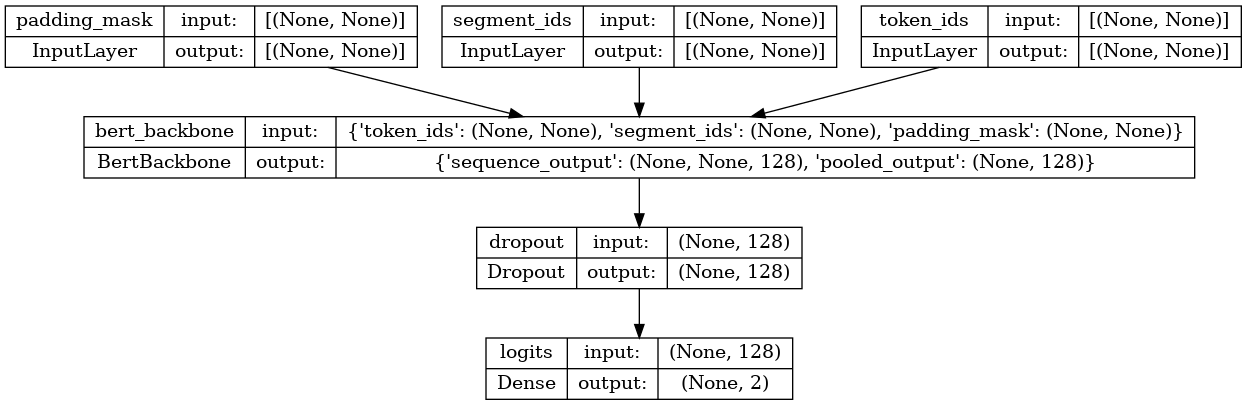

In [17]:
tf.keras.utils.plot_model(classifier, show_shapes=True, show_layer_names=True)

Let's take a look at the layers in the model.

In [18]:
classifier.layers

It looks like the main model is nested in the `BertBackbone` layer (`classifier.layers[3]`).

In [19]:
classifier.layers[3].layers

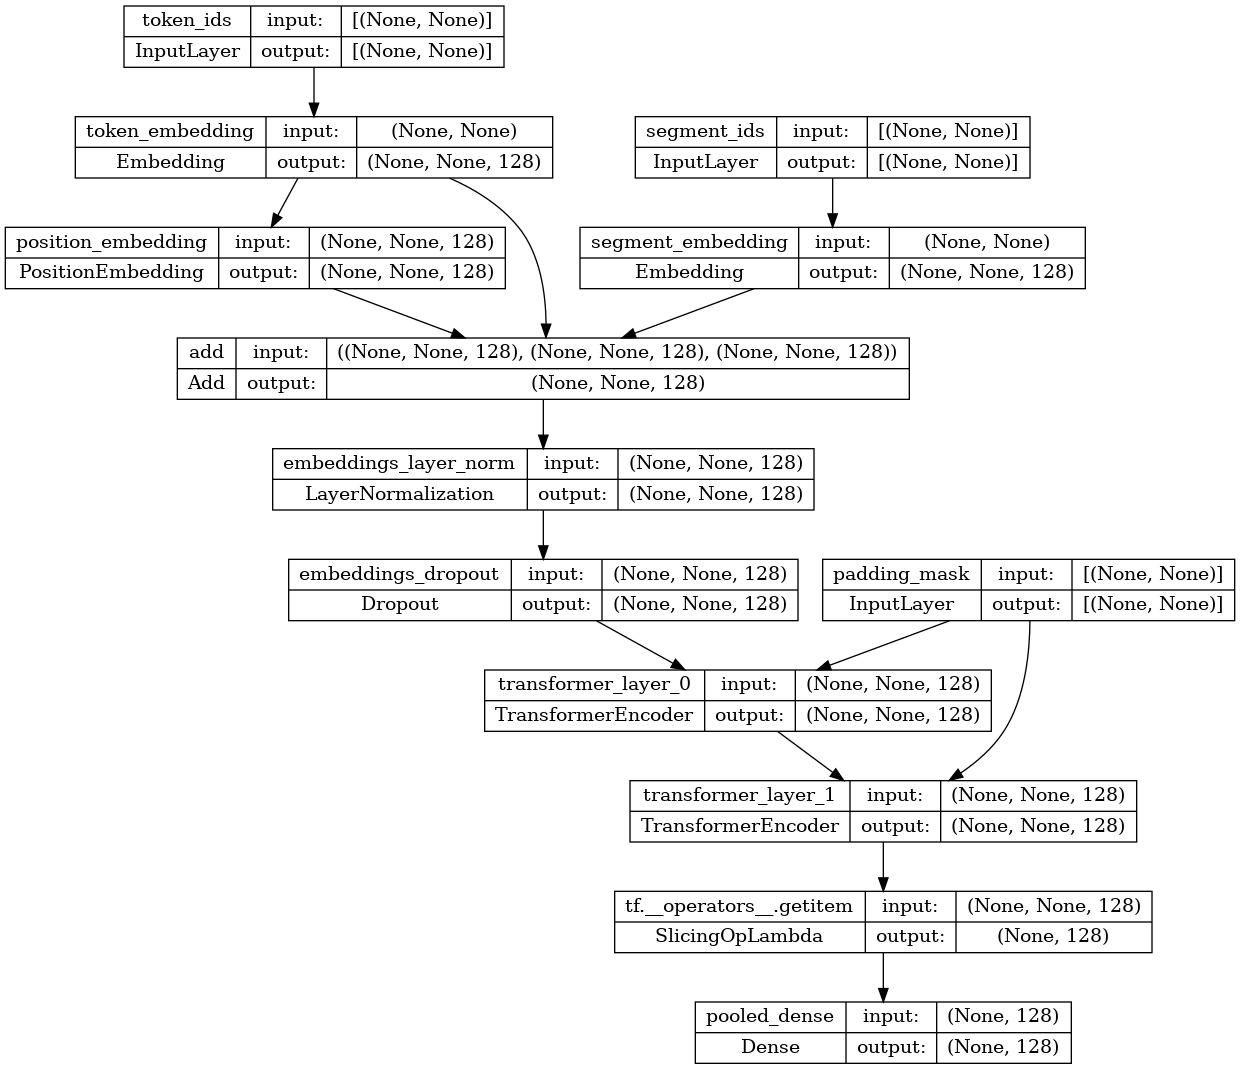

In [20]:
tf.keras.utils.plot_model(
    classifier.layers[3], show_shapes=True, show_layer_names=True
)

We want to get token embeddings. It seems like the output of the `token_embedding` layer (`classifier.layers[3].layers[1]`) produces the token embeddings. However, the final embedding is produced by the `add_1` layer (`classifier.layers[3].layers[5]`) by combining positional encoding.<br>
Also, a Layer Normalization layer (`classifier.layers[3].layers[6]`) follows it. This embedding seems to be a good target for gradient-based interpretability.

Let's define a standalone module until this layer. Here, we can find nested layers. Let's visualize the graph.

In [21]:
embedding_model = tf.keras.Model(
    inputs=classifier.input, outputs=classifier.layers[3].layers[6].output
)

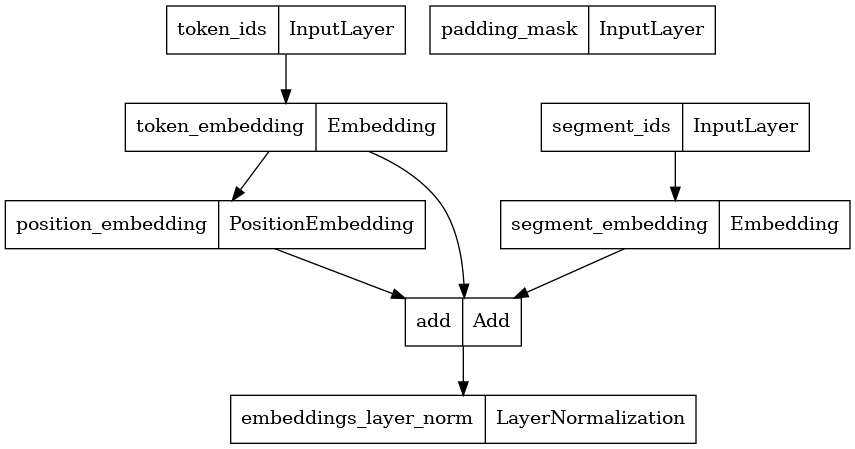

In [22]:
tf.keras.utils.plot_model(embedding_model)

The main BERT model follows it. Here, we similarly define a remaining BERT backbone as a standalone module.

In [23]:
bert_backbone = tf.keras.Model(
    inputs=[
        classifier.layers[3].layers[7].input,
        classifier.layers[3].layers[8].input,
    ],
    outputs=classifier.layers[3].layers[-1].output,
)

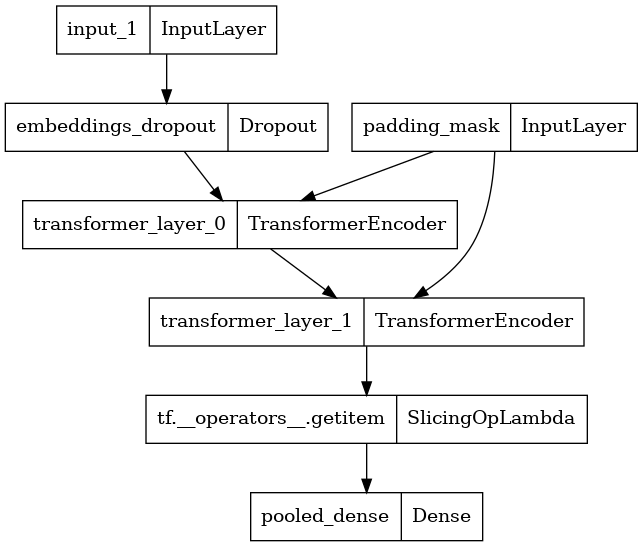

In [24]:
tf.keras.utils.plot_model(bert_backbone)

Last, we define a classification head, which produces the final logits value from which we calculate the gradients.

In [25]:
cls_head = tf.keras.Model(
    inputs=classifier.layers[-2].input, outputs=classifier.layers[-1].output
)

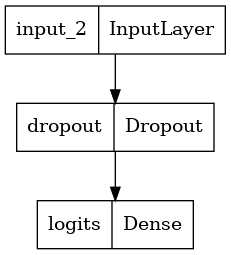

In [26]:
tf.keras.utils.plot_model(cls_head)

We can call these three modules in order to calculate logits from texts. 

In [61]:
data = ImdbSentimentData(test_ds)
text = data.examples[0]["text"]

tokens = classifier._preprocessor(tf.constant([text]))
embeddings = embedding_model(tokens)
bert_output = bert_backbone([embeddings, tokens["padding_mask"]])
logits = cls_head(bert_output)
logits

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 2.6266904, -2.6779945]], dtype=float32)>

### Compute Gradients
In TensorFlow, we can use `tf.GradientTape` context manager to use autograd capability.

If you are using other frameworks, please refer to the documentation about autograd to do the same procedure (e.g. [Pytorch](https://pytorch.org/tutorials/beginner/former_torchies/autograd_tutorial.html), [JAX](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html))

In [45]:
with tf.GradientTape() as tape:
    tape.watch(embeddings)
    bert_output = bert_backbone([embeddings, tokens["padding_mask"]])
    logits = cls_head(bert_output)

    indices = tf.argmax(logits, axis=-1)
    pred = tf.gather_nd(logits, [[i, idx] for i, idx in enumerate(indices)])

input_emb_grads = tape.gradient(pred, embeddings)
input_emb_grads

<tf.Tensor: shape=(1, 512, 128), dtype=float32, numpy=
array([[[-1.2266111e-02, -1.7972630e-02, -2.4448384e-02, ...,
          8.7134004e-02,  2.7757222e-02, -1.9070851e-02],
        [-1.6250003e-03, -7.7768188e-04,  4.9589266e-04, ...,
          5.4970878e-04,  2.4117201e-03,  6.9923373e-04],
        [-2.1806904e-03, -1.7278483e-03, -7.0573296e-04, ...,
         -9.2792936e-04,  9.8060677e-04,  1.1187326e-03],
        ...,
        [-8.1803725e-04,  1.1070468e-03, -1.2024770e-03, ...,
          2.4822948e-06,  2.0791711e-03, -2.3768278e-04],
        [-1.0492257e-03, -9.7427116e-04, -3.4040953e-05, ...,
         -2.6212356e-04,  9.2613348e-04,  9.1896101e-05],
        [-2.2385579e-03, -2.0981238e-03, -1.7014235e-03, ...,
          2.0118098e-04,  9.3238708e-04, -2.4278437e-05]]], dtype=float32)>

### Update LIT Model

Looks great! 

Based on this setup, we can add two gradient-based methods, Gradient Norm and Gradient-dot-Input:

#### Gradient Norm
Gradient Norm is a simple method in which salience scores are proportional to the L2 norm of the gradient, i.e., the score for a token $i$ is:

$S(i)\propto  \|  \nabla _{x_i} \hat{y} \| _2$

#### Gradient-dot-Input
In Gradient-dot-Input, salience scores are proportional to the dot product of the input embeddings and their gradients, i.e., for token $i$, we compute:

$S(i)\propto  x_i \nabla_{x_i} \hat{y} $


Since we already defined $\hat{y}$ in the previous model, there are two additional elements we have to produce: $\nabla _{x_i}$ and $x_i$. 
- $x_i$: token embedding. This is only required by Gradient-dot-Input.
- $\nabla _{x_i}$: Gradient of each token embedding. This is necessary for both Gradient Norm and Gradient-dot-Input.


Let's update the LIT model module to reflect these elements. 

Here are the key updates we make:
- in `__init__()`, we define additional modules discussed above.
- `output_spec()` output now contains three additional key-value specs:
  - `"tokens"`: a list of tokens of shape `(num_tokens)`. For spec, we use `Tokens` LIT type with `parent="text"` to link with the input text.
  - `"input_embedding"`: token embeddings ($x_i$) of shape `(num_tokens, emb_dim)`. For the spec, we use `TokenEmbeddings` LIT type with `align="tokens"`.
  - `"input_emb_grad"`: gradients of token embeddings ($\nabla _{x_i}$) of shape `(num_tokens, emb_dim)`. For the spec, we use `TokenGradients` LIT type with `align="tokens"` and  `grad_for="input_embedding"` to define the link.
- `predict()` now computes gradients using the three sub-modules and `tf.GradientTape` discussed above and returns the three additional elements corresponding to the `output_spec()` spec definition. <br>
Note that we slice the `tokens`, `impute_embedding` and `input_emb_grad` with `[START_OFFSET : slen - END_OFFSET]` where:
  - `START_OFFSET=1` to trim the first `[CLS]` token that doesn't correspond with any elements in the input sentence,
  - `END_OFFSET=1` to trim the `[SEP]` token BERT uses after the first sentence. Note that BERT can take a pair of sentences. `[SEP]` is a separator between them, while we only use a single sentence in this text classification example.
  - `slen` is the length of input tokens.

In [53]:
START_OFFSET = 1  # offset [CLS] token
END_OFFSET = 1  # offset [SEP] token


class BertSentimentModel(lit_model.Model):

    def __init__(self, model):
        self._model = model
        self._embedding_model = tf.keras.Model(
            inputs=model.input, outputs=model.layers[3].layers[6].output
        )
        self._bert_backbone = tf.keras.Model(
            inputs=[
                model.layers[3].layers[7].input,
                model.layers[3].layers[8].input,
            ],
            outputs=model.layers[3].layers[-1].output,
        )
        self._cls_head = tf.keras.Model(
            inputs=classifier.layers[-2].input,
            outputs=classifier.layers[-1].output,
        )

    def _detokenize(self, indices):
        return [
            self._model.preprocessor.tokenizer.vocabulary[idx]
            for idx in indices
        ]

    def predict(self, inputs):
        """Predict on a stream of examples."""
        examples = [d["text"] for d in inputs]
        tokenized = self._model.preprocessor(examples)
        seq_lens = tf.reduce_sum(
            tf.cast(tokenized["padding_mask"], tf.int32), axis=-1
        )
        embeddings = self._embedding_model(tokenized)
        with tf.GradientTape() as tape:
            tape.watch(embeddings)
            bert_output = self._bert_backbone(
                [embeddings, tokenized["padding_mask"]]
            )
            logits = self._cls_head(bert_output)

            if "label" in inputs[0].keys():
                indices = [
                    1 if inp["label"] == LABELS[1] else 0 for inp in inputs
                ]
            else:
                indices = tf.argmax(logits, axis=-1)

            pred = tf.gather_nd(
                logits, [[i, idx] for i, idx in enumerate(indices)]
            )

        probs = tf.keras.activations.softmax(logits)

        input_emb_grads = tape.gradient(pred, embeddings)

        return [
            {
                "prob": prob.numpy(),
                "tokens": self._detokenize(
                    tokens[START_OFFSET : slen - END_OFFSET]
                ),
                "input_embedding": emb[
                    START_OFFSET : slen - END_OFFSET
                ].numpy(),
                "input_emb_grad": grad[
                    START_OFFSET : slen - END_OFFSET
                ].numpy(),
            }
            for prob, tokens, emb, grad, slen in zip(
                probs,
                tokenized["token_ids"],
                embeddings,
                input_emb_grads,
                seq_lens,
            )
        ]

    def input_spec(self):
        """Describe the inputs to the model."""
        return {
            "text": lit_types.TextSegment(),
            "label": lit_types.CategoryLabel(required=False, vocab=LABELS),
        }

    def output_spec(self):
        """Describe the model outputs."""
        return {
            "prob": lit_types.MulticlassPreds(vocab=LABELS, parent="label"),
            "tokens": lit_types.Tokens(parent="text"),
            "input_embedding": lit_types.TokenEmbeddings(align="tokens"),
            "input_emb_grad": lit_types.TokenGradients(
                align="tokens", grad_for="input_embedding"
            ),
        }

Let's render LIT again and check how these changes are reflected in the UI!

In [54]:
# Create the LIT widget with the model and dataset to analyze.
models = {"BERT classifier": BertSentimentModel(classifier)}

widget.stop()
widget = notebook.LitWidget(models, datasets, layouts=layouts, port=8890)

127.0.0.1 - - [09/Sep/2024 11:07:25] "POST /get_info HTTP/1.1" 200 26613
127.0.0.1 - - [09/Sep/2024 11:07:25] "POST /get_dataset?dataset_name=acllmdb HTTP/1.1" 200 161614
127.0.0.1 - - [09/Sep/2024 11:07:26] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
127.0.0.1 - - [09/Sep/2024 11:07:33] "POST /get_metrics?model=BERT%20classifier&dataset_name=acllmdb&metrics=multiclass,paired&do_predict=1 HTTP/1.1" 200 162
127.0.0.1 - - [09/Sep/2024 11:07:33] "POST /get_interpretations?model=BERT%20classifier&dataset_name=acllmdb&interpreter=classification&do_predict=1 HTTP/1.1" 200 17525
127.0.0.1 - - [09/Sep/2024 11:07:33] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
127.0.0.1 - - [09/Sep/2024 11:07:33] "POST /get_metrics?model=BERT%20classifier&dataset_name=acllmdb&metrics=multiclass,paired&do_predict=1 HTTP/1.1" 200 161
127.0.0.1 - - [09/Sep/2024 11:07:37] "POST /get_preds?model=BERT%20classifier&dataset_name=acllmdb&requested_types=MulticlassPreds,RegressionScore&request

In [55]:
widget.render(height=600, open_in_new_tab=True)

## Add Integrated Gradients

The integrated gradient method is a more robust method for estimating feature contribution based on integrating gradients along a path in embedding space. <br>
See [Sundararajan et al. 2017](https://arxiv.org/abs/1703.01365) for additional details on the algorithm. This method may give better results than grad-norm and grad-dot-input but also requires more involved instrumentation of the model.

There are the key updates to use Integrated Gradients:
- `input_spec()` now includes `input_embedding` as an optional key-value (`required=False`), which is the same name as the output `input_embedding` spec. <br>
In Integrated Gradients, LIT computes multiple inputs (token embeddings in this case) perturbations on which we compute gradients, and integrates over them. This optional input is the gate of those perturbations, which will only be passed when we use Integrated Gradients.
- `output_spec()` is almost the same as the previous example, except for the additional `grad_target_field_key="label"` to link with the label field from the input.
- `predict()` now has a conditional operation for Integrated Gradients (i.e., in case the `input_embedding` key is included in inputs). We simply swap the perturbations with the raw embeddings calculated from the original inputs. 

In [80]:
START_OFFSET = 1  # offset [CLS] token
END_OFFSET = 1  # offset [SEP] token


class BertSentimentModel(lit_model.Model):

    def __init__(self, model):
        self._model = model
        self._embedding_model = tf.keras.Model(
            inputs=model.input, outputs=model.layers[3].layers[6].output
        )
        self._bert_backbone = tf.keras.Model(
            inputs=[
                model.layers[3].layers[7].input,
                model.layers[3].layers[8].input,
            ],
            outputs=model.layers[3].layers[-1].output,
        )
        self._cls_head = tf.keras.Model(
            inputs=classifier.layers[-2].input,
            outputs=classifier.layers[-1].output,
        )

    def _detokenize(self, indices):
        return [
            self._model.preprocessor.tokenizer.vocabulary[idx]
            for idx in indices
        ]

    def predict(self, inputs):
        """Predict on a stream of examples."""
        examples = [d["text"] for d in inputs]
        tokenized = self._model.preprocessor(examples)
        seq_lens = tf.reduce_sum(
            tf.cast(tokenized["padding_mask"], tf.int32), axis=-1
        )
        embeddings = self._embedding_model(tokenized)
        if "input_embedding" in inputs[0].keys():
            pertubations = tf.convert_to_tensor(
                [inp["input_embedding"] for inp in inputs]
            )
            step_size, ptb_len, emd_dim = pertubations.shape
            pertubations = tf.reshape(
                pertubations, (step_size * ptb_len, emd_dim)
            )
            update_indices = [
                [s, l + START_OFFSET]
                for s in range(step_size)
                for l in range(ptb_len)
            ]
            embeddings = tf.tensor_scatter_nd_update(
                embeddings, update_indices, pertubations
            )
        with tf.GradientTape() as tape:
            tape.watch(embeddings)
            bert_output = self._bert_backbone(
                [embeddings, tokenized["padding_mask"]]
            )
            logits = self._cls_head(bert_output)
            if "label" in inputs[0].keys():
                indices = [
                    1 if inp["label"] == LABELS[1] else 0 for inp in inputs
                ]
            else:
                indices = tf.argmax(logits, axis=-1)
            pred = tf.gather_nd(
                logits, [[i, idx] for i, idx in enumerate(indices)]
            )

        probs = tf.keras.activations.softmax(logits)

        input_emb_grads = tape.gradient(pred, embeddings)

        return [
            {
                "prob": prob.numpy(),
                "tokens": self._detokenize(
                    tokens[START_OFFSET : slen - END_OFFSET]
                ),
                "input_embedding": emb[
                    START_OFFSET : slen - END_OFFSET
                ].numpy(),
                "input_emb_grad": grad[
                    START_OFFSET : slen - END_OFFSET
                ].numpy(),
            }
            for prob, tokens, emb, grad, slen in zip(
                probs,
                tokenized["token_ids"],
                embeddings,
                input_emb_grads,
                seq_lens,
            )
        ]

    def input_spec(self):
        """Describe the inputs to the model."""
        return {
            "text": lit_types.TextSegment(),
            "label": lit_types.CategoryLabel(required=False, vocab=LABELS),
            "input_embedding": lit_types.TokenEmbeddings(
                required=False, align="tokens"
            ),
        }

    def output_spec(self):
        """Describe the model outputs."""
        return {
            "prob": lit_types.MulticlassPreds(vocab=LABELS, parent="label"),
            "tokens": lit_types.Tokens(parent="text"),
            "input_embedding": lit_types.TokenEmbeddings(align="tokens"),
            "input_emb_grad": lit_types.TokenGradients(
                align="tokens",
                grad_for="input_embedding",
                grad_target_field_key="label",
            ),
        }

In [82]:
# Create the LIT widget with the model and dataset to analyze.
models = {"BERT classifier": BertSentimentModel(classifier)}

widget.stop()
widget = notebook.LitWidget(models, datasets, layouts=layouts, port=8890)

127.0.0.1 - - [09/Sep/2024 13:58:30] "POST /get_info HTTP/1.1" 200 26791
127.0.0.1 - - [09/Sep/2024 13:58:30] "POST /get_dataset?dataset_name=acllmdb HTTP/1.1" 200 161614
127.0.0.1 - - [09/Sep/2024 13:58:30] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
127.0.0.1 - - [09/Sep/2024 13:58:37] "POST /get_metrics?model=BERT%20classifier&dataset_name=acllmdb&metrics=multiclass,paired&do_predict=1 HTTP/1.1" 200 162
127.0.0.1 - - [09/Sep/2024 13:58:37] "POST /get_interpretations?model=BERT%20classifier&dataset_name=acllmdb&interpreter=classification&do_predict=1 HTTP/1.1" 200 17525
127.0.0.1 - - [09/Sep/2024 13:58:37] "GET /static/onboarding_1_welcome.gif HTTP/1.1" 200 584363
127.0.0.1 - - [09/Sep/2024 13:58:37] "POST /get_metrics?model=BERT%20classifier&dataset_name=acllmdb&metrics=multiclass,paired&do_predict=1 HTTP/1.1" 200 161
127.0.0.1 - - [09/Sep/2024 13:58:37] "POST /push_ui_state?dataset_name=acllmdb HTTP/1.1" 200 4
127.0.0.1 - - [09/Sep/2024 13:58:37] "POST /get_interpreta

Let's render the LIT UI again. 

Click the arrow on In Integrated Gradients to compute the saliency with it since it requires additional computation.

Also, from the configuration button, you can change the step size (number of perturbations you'll approximate integral with) between 5 and 100—the higher the value, the more accurate, but the more computationally expensive.
<img width="700" alt="image" src="https://github.com/user-attachments/assets/1f41aaeb-df8a-4d06-9191-de7853f1bfc0">


In [83]:
widget.render(height=600, open_in_new_tab=True)

## (Optional) Directly Call Interpretability modules

You may want to get saliency values directly outside of the LIT UI. You can call each component using the same model object.

For example, for Integrated Gradients:

In [78]:
from lit_nlp.components import gradient_maps

ig = gradient_maps.IntegratedGradients()

saliency = ig.run(
    ImdbSentimentData(test_ds).examples[:1],
    BertSentimentModel(classifier),
    ImdbSentimentData(test_ds),
)
saliency

[{'input_emb_grad': TokenSalience(tokens=['the', 'movie', 'is', 'precious', ',', 'and', 'cage', 'is', 'a', 'babe', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'but', 'will', 'anyone', 'agree', 'with', 'me', 'in', 'saying', 'that', 'the', 'punk', 'representation', 'in', 'this', 'movie', 'is', 'at', '##ro', '##cious', '?', '!', '?', '!', '<', 'br', '/', '>', '<', 'br', '/', '>', 'where', "'", 's', 'the', 'clash', '?', 'the', 'ramon', '##es', '?', '?', 'mis', '##fi', '##ts', '?', 'social', 'distortion', '?', 'the', 'cr', '##amps', '?', '?', 'sex', 'pistols', '?', '!', 'anyone', '?', '!', '?', '!', '?', '!', '?', '!', 'the', 'music', 'is', 'this', 'movie', 'is', 'incredibly', 'disappointing', '!', 'at', 'least', 'they', 'play', 'the', 'cure', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'plus', ',', 'randy', "'", 's', 'feather', '##ed', 'hair', 'and', 'plea', '##ted', 'k', '##hak', '##is', '.', '.', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'this', 'definitely', 'looks', 'like', 

In [86]:
df = pd.DataFrame(
    [
        saliency[0]["input_emb_grad"].tokens,
        saliency[0]["input_emb_grad"].salience,
    ],
    index=["token", "salience"],
)

salience_series = saliency[0]["input_emb_grad"].salience
abs_max = max(abs(salience_series.max()), abs(salience_series.min()))
df.style.background_gradient(
    axis=1,
    gmap=df.loc["salience", :].apply(pd.to_numeric),
    vmin=-abs_max,
    vmax=abs_max,
    cmap="seismic",
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202
token,the,movie,is,precious,",",and,cage,is,a,babe,.,<,br,/,>,<,br,/,>,but,will,anyone,agree,with,me,in,saying,that,the,punk,representation,in,this,movie,is,at,##ro,##cious,?,!,?,!,<,br,/,>,<,br,/,>,where,',s,the,clash,?,the,ramon,##es,?,?,mis,##fi,##ts,?,social,distortion,?,the,cr,##amps,?,?,sex,pistols,?,!,anyone,?,!,?,!,?,!,?,!,the,music,is,this,movie,is,incredibly,disappointing,!,at,least,they,play,the,cure,.,<,br,/,>,<,br,/,>,plus,",",randy,',s,feather,##ed,hair,and,plea,##ted,k,##hak,##is,.,.,.,<,br,/,>,<,br,/,>,this,definitely,looks,like,a,movie,about,"""",punk,##s,"""",the,way,that,a,bunch,of,movie,industry,squares,see,punk,##s,.,<,br,/,>,<,br,/,>,although,it,',s,a,90,',s,movie,",",sl,##c,punk,paints,a,much,more,accurate,picture,of,the,punk,rock,scene,in,the,early,1980,',s,.,just,say,##in,',.
salience,-0.003125,0.000055,0.001532,0.002891,-0.004705,-0.005820,0.005643,0.001845,-0.002571,-0.004973,-0.001079,-0.001879,-0.006945,-0.001118,0.003429,-0.001715,-0.007308,-0.001248,0.001824,-0.000929,-0.006582,-0.001079,-0.001127,-0.004227,-0.004420,-0.003907,0.008929,-0.000727,-0.001560,-0.000767,0.001385,-0.003371,0.000841,-0.000632,0.005985,0.000292,0.008366,0.017231,0.010202,-0.004501,0.009431,-0.006993,-0.002311,-0.006982,-0.001612,-0.001346,-0.004612,-0.007687,-0.001471,0.002498,0.000149,0.001688,-0.002317,-0.001540,0.005606,0.013998,-0.000669,-0.005990,-0.001559,0.013590,0.013140,0.053973,0.003797,0.002326,0.012143,0.000027,0.009192,0.012819,-0.002771,0.002842,0.009120,0.013595,0.012653,0.000484,0.013400,0.013324,-0.005784,-0.001456,0.013135,-0.007665,0.013259,-0.007274,0.012402,-0.006322,0.012534,-0.008035,-0.002477,-0.010489,0.003209,0.001200,0.002259,0.004774,0.002939,0.055479,-0.006752,0.000498,0.006832,-0.001610,-0.002825,-0.001433,0.010190,-0.000322,-0.003314,-0.007866,-0.000711,0.000806,-0.003136,-0.007326,0.000494,0.001358,-0.003384,-0.003191,-0.004095,-0.000059,-0.002815,-0.016026,0.006768,-0.002393,-0.003277,0.001194,-0.002228,-0.003358,-0.008515,-0.008882,0.000149,-0.000829,-0.000684,-0.003167,-0.006841,-0.000809,0.004011,-0.002704,-0.006384,-0.001342,0.002615,0.000857,-0.030774,0.021823,0.002120,-0.002160,-0.000524,-0.001180,0.001490,-0.001340,0.000556,0.000234,-0.001745,-0.001402,-0.000643,-0.001052,0.016571,-0.000136,0.001183,0.004155,-0.001001,-0.009190,-0.004771,-0.000046,0.000079,-0.002770,-0.006862,-0.000912,0.002840,-0.002384,-0.006706,-0.001054,0.002789,-0.001981,-0.016658,0.000100,-0.002997,-0.004302,-0.000787,-0.000583,-0.002655,-0.001700,-0.002792,0.014911,0.001270,-0.002840,-0.012728,-0.003903,0.004282,-0.002131,0.001424,0.002956,0.000621,-0.002815,-0.001746,-0.007868,0.002390,-0.001544,-0.002801,-0.001669,-0.012581,0.000326,-0.002405,0.000502,0.006338,0.003693,0.003536,-0.000466,-0.000047


## What's next?

To learn more about LIT and AI Explanations, check out the resources here.

- [LIT documentation](https://pair-code.github.io/lit/)
- [LIT github](https://github.com/PAIR-code/lit)
- [Integrated gradients paper](https://arxiv.org/abs/1703.01365)

Copyright 2024 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License